In [2]:
import tqdm 
from tqdm import tqdm
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy import units as u
from astropy import constants as c
from astropy.io import fits 
from astropy.io import ascii
from astropy.table import QTable, Table
from astropy.cosmology import WMAP9 as cosmo
from astropy.coordinates import SkyCoord

# I. Preliminaries

## 1. SN Catalog

In [3]:
# 1) HEAD FILE 
f = fits.open('DES-SN5YR_DES_HEAD.FITS')
t = Table(f[1].data)

# 2) PHOT FILE 
dat = fits.open('DES-SN5YR_DES_PHOT.FITS')
tb = Table(dat[1].data)
flux = tb['FLUXCAL'].data
fluxerr = tb['FLUXCALERR'].data

# 3) CLASSIFICATION CSV
c = pd.read_csv('DES_classification.csv')     # note this is 1635 total 
cids = c['CID'].values.astype(int) 

goodsn = c[c['PROB_SNNV19'] > 0.5]            # this is 1499 
goodsnids = goodsn['CID'].values
goodsnids = goodsnids.astype(int)

common_ids = np.intersect1d(t['SNID'].data.astype(int), cids)    # 1635 

# 4) MAKING NEW DATAFRAME 
inds = list(zip(t[t['SNTYPE'] == 1]['PTROBS_MIN'], t[t['SNTYPE'] == 1]['PTROBS_MAX']))
reds = t[t['SNTYPE'] == 1]['REDSHIFT_FINAL'].data
redss = reds[reds < 0.5]

inds = np.array(inds)
indss = inds[reds < 0.5]

snrows = [np.where(t['SNID'].data.astype(int) == cids.astype(int)[i])[0][0] for i in range(len(cids))]

snra = t[snrows]['RA'].data
sndec = t[snrows]['DEC'].data
snpeakmjd = t[snrows]['PEAKMJD'].data
snmjddetectfirst = t[snrows]['MJD_DETECT_FIRST'].data
snmjddetectlast = t[snrows]['MJD_DETECT_LAST'].data
snptrobs_min = t[snrows]['PTROBS_MIN'].data
snptrobs_max = t[snrows]['PTROBS_MAX'].data
snredshift_final = t[snrows]['REDSHIFT_FINAL'].data
snmjd = [tb[snptrobs_min[i]:snptrobs_max[i]]['MJD'].data for i in range(len(snrows))]
snband = [tb[snptrobs_min[i]:snptrobs_max[i]]['BAND'].data for i in range(len(snrows))]
snfluxcal = [tb[snptrobs_min[i]:snptrobs_max[i]]['FLUXCAL'].data for i in range(len(snrows))]
snfluxcalerr = [tb[snptrobs_min[i]:snptrobs_max[i]]['FLUXCALERR'].data for i in range(len(snrows))]

hostgal_objid = t[snrows]['HOSTGAL_OBJID']
hostgal_photoz = t[snrows]['HOSTGAL_PHOTOZ']  # all -999 
hostgal_photoz_err = t[snrows]['HOSTGAL_PHOTOZ_ERR']  # all -999
hostgal_specz = t[snrows]['HOSTGAL_SPECZ']
hostgal_specz_err = t[snrows]['HOSTGAL_SPECZ_ERR']
hostgal_ra = t[snrows]['HOSTGAL_RA']
hostgal_dec = t[snrows]['HOSTGAL_DEC']
hostgal_logmass = t[snrows]['HOSTGAL_LOGMASS']
hostgal_logmass_err = t[snrows]['HOSTGAL_LOGMASS_ERR']
hostgal_logsfr = t[snrows]['HOSTGAL_LOGSFR']         # all -9999
hostgal_logsfr_err = t[snrows]['HOSTGAL_LOGSFR_ERR'] # all -9999
hostgal_color = t[snrows]['HOSTGAL_COLOR']           # all -9999
hostgal_color_err = t[snrows]['HOSTGAL_COLOR_ERR']   # all -9999
hostgal_sqradius = t[snrows]['HOSTGAL_SQRADIUS']     # all -9999

sntimes = [(snmjd[i] - snpeakmjd[i]) / (1 + snredshift_final[i]) for i in range(len(snrows))]


tnew = QTable([cids, snrows, snra, sndec, snpeakmjd, snmjddetectfirst, snmjddetectlast, snptrobs_min, snptrobs_max, snredshift_final, 
              snmjd, snband, snfluxcal, snfluxcalerr,
              hostgal_objid, hostgal_photoz, hostgal_photoz_err, hostgal_specz, hostgal_specz_err, 
               hostgal_ra, hostgal_dec, hostgal_logmass, hostgal_logmass_err, hostgal_logsfr, hostgal_logsfr_err,
               hostgal_color, hostgal_color_err, hostgal_sqradius],
           names=('CID', 'ROW', 'RA', 'DEC', 'PEAKMJD', 'MJD_DETECT_FIRST', 'MJD_DETECT_LAST', 'PTROBS_MIN', 'PTROBS_MAX', 'REDSHIFT_FINAL',
                 'MJD', 'BAND', 'FLUXCAL', 'FLUXCALERR', 
                  'HOSTGAL_OBJID', 'HOSTGAL_PHOTOZ', 'HOSTGAL_PHOTOZ_ERR', 'HOSTGAL_SPECZ', 'HOSTGAL_SPECZ_ERR', 
                  'HOSTGAL_RA', 'HOSTGAL_DEC', 'HOSTGAL_LOGMASS', 'HOSTGAL_LOGMASS_ERR', 
                  'HOSTGAL_LOGSFR', 'HOSTGAL_LOGSFR_ERR', 'HOSTGAL_COLOR', 'HOSTGAL_COLOR_ERR', 'HOSTGAL_SQRADIUS'),
           meta={'name': 'master table'})


In [4]:
t

SNID,IAUC,FAKE,MASK_FLUXCOR_SNANA,RA,DEC,PIXSIZE,NXPIX,NYPIX,SNTYPE,NOBS,PTROBS_MIN,PTROBS_MAX,MWEBV,MWEBV_ERR,REDSHIFT_HELIO,REDSHIFT_HELIO_ERR,REDSHIFT_FINAL,REDSHIFT_FINAL_ERR,REDSHIFT_QUALITYFLAG,VPEC,VPEC_ERR,HOSTGAL_NMATCH,HOSTGAL_NMATCH2,HOSTGAL_OBJID,HOSTGAL_FLAG,HOSTGAL_PHOTOZ,HOSTGAL_PHOTOZ_ERR,HOSTGAL_SPECZ,HOSTGAL_SPECZ_ERR,HOSTGAL_RA,HOSTGAL_DEC,HOSTGAL_SNSEP,HOSTGAL_DDLR,HOSTGAL_CONFUSION,HOSTGAL_LOGMASS,HOSTGAL_LOGMASS_ERR,HOSTGAL_LOGSFR,HOSTGAL_LOGSFR_ERR,HOSTGAL_LOGsSFR,HOSTGAL_LOGsSFR_ERR,HOSTGAL_COLOR,HOSTGAL_COLOR_ERR,HOSTGAL_ELLIPTICITY,HOSTGAL_OBJID2,HOSTGAL_SQRADIUS,HOSTGAL_OBJID_UNIQUE,HOSTGAL_MAG_g,HOSTGAL_MAG_r,HOSTGAL_MAG_i,HOSTGAL_MAG_z,HOSTGAL_MAGERR_g,HOSTGAL_MAGERR_r,HOSTGAL_MAGERR_i,HOSTGAL_MAGERR_z,HOSTGAL2_OBJID,HOSTGAL2_FLAG,HOSTGAL2_PHOTOZ,HOSTGAL2_PHOTOZ_ERR,HOSTGAL2_SPECZ,HOSTGAL2_SPECZ_ERR,HOSTGAL2_RA,HOSTGAL2_DEC,HOSTGAL2_SNSEP,HOSTGAL2_DDLR,HOSTGAL2_LOGMASS,HOSTGAL2_LOGMASS_ERR,HOSTGAL2_LOGSFR,HOSTGAL2_LOGSFR_ERR,HOSTGAL2_LOGsSFR,HOSTGAL2_LOGsSFR_ERR,HOSTGAL2_COLOR,HOSTGAL2_COLOR_ERR,HOSTGAL2_ELLIPTICITY,HOSTGAL2_OBJID2,HOSTGAL2_SQRADIUS,HOSTGAL2_OBJID_UNIQUE,HOSTGAL2_MAG_g,HOSTGAL2_MAG_r,HOSTGAL2_MAG_i,HOSTGAL2_MAG_z,HOSTGAL2_MAGERR_g,HOSTGAL2_MAGERR_r,HOSTGAL2_MAGERR_i,HOSTGAL2_MAGERR_z,HOSTGAL_SB_FLUXCAL_g,HOSTGAL_SB_FLUXCAL_r,HOSTGAL_SB_FLUXCAL_i,HOSTGAL_SB_FLUXCAL_z,PEAKMJD,MJD_TRIGGER,MJD_DETECT_FIRST,MJD_DETECT_LAST,SEARCH_TYPE,PRIVATE(AGN_SCAN)
str16,str16,int16,int16,float64,float64,float32,int16,int16,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,int16,float32,float32,int16,int16,int64,int16,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,int64,int16,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64
1642082,UNKNOWN,0,0,35.169212,-5.698688,0.263,2048,4096,0,55,1,55,0.021179553,0.0010589777,0.4357,0.001,0.434529,0.001,0,0.0,300.0,1,2,112224,0,-999.0,-999.0,0.4357,0.001,35.169116,-5.698704,0.348,0.242,-99.0,10.371,0.023,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0,-9999.0,0,22.45,21.43,21.02,20.72,0.01,0.0,0.0,0.0,112225,0,-999.0,-999.0,-999.0,-999.0,35.167386,-5.69805,6.934,6.551,-999.0,-999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0,-9999.0,0,24.88,23.65,22.51,22.0,0.05,0.02,0.01,0.01,27.12,78.25,109.33,138.82,57739.117,57756.07,57739.117,57756.07,-9,-1.0
1294480,UNKNOWN,0,0,34.010349,-5.38346,0.263,2048,4096,0,108,57,164,0.018494692,0.0009247346,0.34536,0.001,0.344237,0.001,0,0.0,300.0,1,2,-4939,0,-999.0,-999.0,0.3454,0.001,34.01052,-5.383614,0.826,0.681,-99.0,10.845,0.036,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0,-9999.0,0,22.29,20.55,19.82,19.45,0.01,0.0,0.0,0.0,-4935,0,-999.0,-999.0,-999.0,-999.0,34.011465,-5.383816,4.201,6.597,-999.0,-999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0,-9999.0,0,24.9,23.32,22.78,22.46,0.06,0.01,0.01,0.01,28.95,138.47,249.43,354.04,56956.086,-9.0,56956.086,57311.11,-9,-1.0
1402031,UNKNOWN,0,0,8.426459,-44.096779,0.263,2048,4096,0,16,166,181,0.0052085603,0.000260428,-999.0,-9.0,-999.0,-9.0,0,0.0,300.0,1,1,427005,0,-999.0,-999.0,-999.0,-999.0,8.426459,-44.096779,0.0,0.0,-99.0,-999.0,-999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0,-9999.0,0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,0,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-9.0,-9.0,-999.0,-9.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0,-9999.0,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-1.51,2.42,1.83,-1.64,0.01,-9.0,57642.11,-9.0,-9,-1.0
1690045,UNKNOWN,0,0,34.245853,-5.856924,0.263,2048,4096,0,111,183,293,0.020252118,0.0010126058,-9

## 2. Galaxy catalog

In [5]:
df = pd.read_csv('gal_df_updated.csv')   # with added magnitude weights 
df   

,Unnamed: 0,GALID,RA_GAL,DEC_GAL,ZTRUE,ZERR,g_obs,r_obs,i_obs,z_obs,...,Sersic_area,g_obs_auto,r_obs_auto,i_obs_auto,z_obs_auto,obs_gr,NBR_LIST,LOGSFR_TRUE,griz,weight
0,0,4300000007,52.258174,-28.585640,0.699000,1.552626,22.666263,22.870720,24.456583,24.401214,...,0.135519,27.099511,25.655767,25.484381,25.776878,-0.204457,"102,71,85",0.221817,94.394780,0.8
1,1,4300000011,52.077320,-28.585696,1.433820,0.001000,23.491464,23.569005,24.809463,24.973073,...,0.013589,25.477124,25.434409,25.435946,25.225667,-0.077541,-1,0.765090,96.843005,0.6
2,2,4300000013,52.124443,-28.585687,0.230925,0.668835,22.125786,23.103293,23.058659,23.022337,...,0.016325,24.919264,24.487260,23.883548,23.774843,-0.977507,"38,133",-0.644414,91.310075,0.9
3,3,4300000014,52.186708,-28.585673,0.785695,1.558499,22.414150,21.903005,23.226666,23.243523,...,1.109612,24.743234,24.165644,24.150354,24.301115,0.511145,37,0.610736,90.787344,0.9
4,4,4300000021,52.106567,-28.585666,0.229480,0.001000,23.154393,23.780093,24.567752,24.951861,...,0.088674,25.689114,25.415451,25.141860,25.146109,-0.625700,45,-0.842706,96.454099,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4179384,4179384,4200805417,54.076851,-29.447326,1.623660,0.001000,25.649645,25.383804,24.953964,24.206734,...,0.000018,25.825964,25.605411,25.143199,24.449171,0.265841,"4179186,4179233,4179370",2.181574,100.194147,0.3
4179385,4179385,4200805418,54.154377,-29.446147,0.806310,0.952698,25.984977,24.939956,23.787159,23.271939,...,0.454683,27.498314,25.011402,23.849720,23.408727,1.045021,"4179335,4179307,4177801,4177764,4179145,417781...",0.706400,97.984031,0.5
4179386,4179386,4200805420,54.142957,-29.447960,0.854230,0.096713,24.211548,22.786839,21.658322,20.970408,...,1.333792,24.265642,22.884178,21.720228,21.051736,1.424709,"4177766,4177773,4177799,4177749",1.948950,89.627117,1.0
4179387,4179387,4200805423,54.121871,-29.447738,1.205000,0.345354,26.032564,24.135847,23.437828,22.483149,...,0.934578,26.377935,24.198956,23.550686,23.404599,1.896717,"4177777,4177750",1.991040,96.089388,0.7


In [6]:
## accounting for SN without matches in galaxy catalog, and galaxies with redshift 0
hostgal_big_is = np.load('hostgal_UNIQUE_ind.npy')


In [7]:
### 0) get rid of the galaxies in Helen dataframe with redshift 0, and also get rid of the SN without matches. 
# going to redo this 
nozmatch = np.load('nozmatch.npy') 

# dropped_df = df.drop(np.where((gal_angdist_all == 0) == True)[0])      # or where df[df['ZTRUE'] == 0]
dropped_df = df.drop(np.where(df['ZTRUE'] == 0)[0])
dropped_df
dropped_tnew = tnew[np.setdiff1d(np.arange(0, 1635, 1), nozmatch)]

In [8]:
## for all galaxies 
new_dropped_df = dropped_df.drop(columns=['Unnamed: 0'])
new_dropped_df = new_dropped_df.reset_index()
new_dropped_df = new_dropped_df.rename(columns={'index': 'old_index'})
new_dropped_df

,old_index,GALID,RA_GAL,DEC_GAL,ZTRUE,ZERR,g_obs,r_obs,i_obs,z_obs,...,Sersic_area,g_obs_auto,r_obs_auto,i_obs_auto,z_obs_auto,obs_gr,NBR_LIST,LOGSFR_TRUE,griz,weight
0,0,4300000007,52.258174,-28.585640,0.699000,1.552626,22.666263,22.870720,24.456583,24.401214,...,0.135519,27.099511,25.655767,25.484381,25.776878,-0.204457,"102,71,85",0.221817,94.394780,0.8
1,1,4300000011,52.077320,-28.585696,1.433820,0.001000,23.491464,23.569005,24.809463,24.973073,...,0.013589,25.477124,25.434409,25.435946,25.225667,-0.077541,-1,0.765090,96.843005,0.6
2,2,4300000013,52.124443,-28.585687,0.230925,0.668835,22.125786,23.103293,23.058659,23.022337,...,0.016325,24.919264,24.487260,23.883548,23.774843,-0.977507,"38,133",-0.644414,91.310075,0.9
3,3,4300000014,52.186708,-28.585673,0.785695,1.558499,22.414150,21.903005,23.226666,23.243523,...,1.109612,24.743234,24.165644,24.150354,24.301115,0.511145,37,0.610736,90.787344,0.9
4,4,4300000021,52.106567,-28.585666,0.229480,0.001000,23.154393,23.780093,24.567752,24.951861,...,0.088674,25.689114,25.415451,25.141860,25.146109,-0.625700,45,-0.842706,96.454099,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4179367,4179384,4200805417,54.076851,-29.447326,1.623660,0.001000,25.649645,25.383804,24.953964,24.206734,...,0.000018,25.825964,25.605411,25.143199,24.449171,0.265841,"4179186,4179233,4179370",2.181574,100.194147,0.3
4179368,4179385,4200805418,54.154377,-29.446147,0.806310,0.952698,25.984977,24.939956,23.787159,23.271939,...,0.454683,27.498314,25.011402,23.849720,23.408727,1.045021,"4179335,4179307,4177801,4177764,4179145,417781...",0.706400,97.984031,0.5
4179369,4179386,4200805420,54.142957,-29.447960,0.854230,0.096713,24.211548,22.786839,21.658322,20.970408,...,1.333792,24.265642,22.884178,21.720228,21.051736,1.424709,"4177766,4177773,4177799,4177749",1.948950,89.627117,1.0
4179370,4179387,4200805423,54.121871,-29.447738,1.205000,0.345354,26.032564,24.135847,23.437828,22.483149,...,0.934578,26.377935,24.198956,23.550686,23.404599,1.896717,"4177777,4177750",1.991040,96.089388,0.7


In [9]:
hostgal_big_is_galids = df.loc[hostgal_big_is]['GALID'].values  # hostgal_big_is gives the index of the hostgal in the original helen dataframe
dropped_hostgal_big_is_galids = hostgal_big_is_galids[np.setdiff1d(np.arange(0, 1635, 1), nozmatch)]
dropped_hostgal_big_is_galids
# this above is me trying to do the "correct" way ^ 

# actually this works because the dataframe retains the original index due to an extra column <- sketchy, just make a new arr
dropped_hostgal_big_is = hostgal_big_is[np.setdiff1d(np.arange(0, 1635, 1), nozmatch)]
dropped_hosts = df.loc[dropped_hostgal_big_is]

# dropped_df[dropped_df['GALID'] == dropped_hostgal_big_is_galids]#  
# dropped_hostgal_big_is = hostgal_big_is[np.setdiff1d(np.arange(0, 1635, 1), nozmatch)]
# dropped_hostgal_big_is  
# < - this gets all the indices of the dropped df wrong though, since it corresponds to the galaxies in the initial df
# ^ use the galids in the original df instead

In [10]:
new_dropped_hosts = dropped_hosts.drop(columns=['Unnamed: 0'])
new_dropped_hosts = new_dropped_hosts.reset_index()    ## index column is the ORIGINAL INDEX IN THE UNDROPPED UNTOUCHED DF 
# df.to_csv('new_dropped_hosts')
# new_dropped_hosts = new_dropped_hosts.rename(columns={'index': 'old_index'})
new_dropped_hosts = new_dropped_hosts.rename(columns={'index': 'old_index'})
new_dropped_hosts 

,old_index,GALID,RA_GAL,DEC_GAL,ZTRUE,ZERR,g_obs,r_obs,i_obs,z_obs,...,Sersic_area,g_obs_auto,r_obs_auto,i_obs_auto,z_obs_auto,obs_gr,NBR_LIST,LOGSFR_TRUE,griz,weight
0,2028493,4100472592,54.647325,-26.401075,0.246510,0.001000,20.558913,20.043122,19.758621,19.674982,...,0.201154,20.654821,20.054606,19.772133,19.690190,0.515791,"2028292,2028458,2028470,2028484,2028423",0.850371,80.035638,1.0
1,1820500,4100079513,53.726236,-27.622179,0.336210,0.001000,19.373273,18.752263,18.566151,18.222731,...,0.947264,19.356433,18.655833,18.433097,18.048661,0.621010,1820455,1.784145,74.914418,1.0
2,1975227,4100373083,54.836542,-26.640205,0.383880,0.001000,22.987223,21.884973,21.497041,21.192465,...,0.250076,23.101433,22.027464,21.672947,21.370653,1.102250,"1975203,1975181,1975353,1975128,1976018,197522...",0.543834,87.561702,1.0
3,843868,2300813852,36.019243,-5.015785,0.321840,0.001000,19.912170,18.464601,17.966664,17.663244,...,2.204251,19.990944,18.548226,18.037371,17.715301,1.447569,-1,1.378371,74.006679,1.0
4,847444,2300821684,36.113870,-4.943922,0.497970,0.001000,23.257735,21.603039,21.029541,20.511257,...,1.051976,23.221373,21.518795,20.950073,20.451007,1.654696,"847591,847222,847485,847067",1.119820,86.401572,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1538,657102,2300387914,35.975497,-3.851290,0.345453,0.000053,21.036343,19.598830,19.180661,18.844690,...,0.319947,21.226086,19.787854,19.258433,18.905645,1.437513,"656586,656620",1.065752,78.660524,1.0
1539,210451,4300534298,53.027475,-27.998611,1.020000,0.001000,24.870839,23.984685,23.201645,22.539578,...,0.032093,25.125324,24.301786,23.406498,22.658351,0.886154,"210685,210453,210561,210601",2.179339,94.596747,0.8
1540,1888847,4100213157,54.209708,-27.262341,0.688910,0.001000,23.567168,22.708640,22.131204,21.930777,...,0.875692,23.607740,22.678899,22.154298,21.965915,0.858528,-1,1.063998,90.337789,0.9
1541,4142086,4200734883,54.473477,-28.942285,0.611940,0.001000,22.853870,21.216939,20.457912,20.012660,...,0.777451,22.866130,21.246804,20.478898,20.036290,1.636931,"4141986,4142445,4142629",1.639667,84.541381,1.0


## 3. Extracting color 

In [11]:
# FITRES file 
with open('FITOPT/FITOPT005.FITRES','r') as file5_:
    fitres5 = file5_.readlines()
    
for i in range(len(fitres5)): 
    fitres5[i] = fitres5[i].rstrip('\n')

head5 = fitres5[5]
fitres5_ = [fitres5[i].split(' ') for i in range(1, len(fitres5))]
varnames = np.delete(np.copy(fitres5_[4][:-1]), 1)

fitres5 = fitres5_.copy()[6:]
bads = np.where(np.array([len(fitres5[i]) for i in range(len(fitres5))]) != 58)
mask = np.delete(np.arange(len(fitres5)), bads[0])
fitres5_cp = np.array([fitres5[mask[i]] for i in range(len(mask))])
mask = np.delete(np.arange(len(fitres5)), bads[0])
fitres5_cp = np.array([fitres5[mask[i]] for i in range(len(mask))])

In [12]:
fits_1635sn = [1] * 1635

for i, cid in enumerate(cids): 
    ind_init = np.where(fitres5_cp[:, 1].astype(int) == cids[i])[0]
    if len(ind_init) == 0:     # accounting for no models there 
        fits_1635sn[i] = np.full(1, np.nan)
    else: 
        ind = ind_init[0]
        fits_1635sn[i] = fitres5_cp[ind]


In [13]:
inds_all_sn = np.where([fitres5_cp[:, 1].astype(int) == cids[i] for i in range(len(cids))])[1]
inds_all_sn.shape      # not all 1635 color

(1626,)

In [14]:
## getting color for each sn
colors = np.ones(len(tnew['CID'].data)) * np.nan

for i, cid in enumerate(tnew['CID'].data):
    m = np.where(fitres5_cp[:, 1].astype(int) == cid)[0]
    l = len(m)
    if l != 0: 
        ind = m[0]
        c = fitres5_cp[ind][46]
        colors[i] = c

In [15]:
## x1 for each sn
x1s = np.ones(len(tnew['CID'].data)) * np.nan

for i, cid in enumerate(tnew['CID'].data):
    m = np.where(fitres5_cp[:, 1].astype(int) == cid)[0]
    l = len(m)
    if l != 0: 
        ind = m[0]
        x1 = fitres5_cp[ind][44]
        x1s[i] = x1

In [16]:
### accounting for color bias
dropped_colors = colors[np.setdiff1d(np.arange(0, 1635, 1), nozmatch)]
dropped_x1s = x1s[np.setdiff1d(np.arange(0, 1635, 1), nozmatch)]

bias_cneg = np.load('c < -0.1_|x1| < 0.40.npz')['dcmeans']
bias_cneut = np.load('|c| < 0.1_|x1| < 0.40.npz')['dcmeans']
bias_cpos = np.load('c > 0.1_|x1| < 0.40.npz')['dcmeans']
zbins = np.load('zbins.npy')

## assign color bias value to EACH SN in dropped_colors based on: 1) its color 2) its redshift
cconds = [(dropped_colors < -0.1), (np.abs(dropped_colors) < 0.1), (dropped_colors > 0.1)]
dropped_reds = dropped_tnew['REDSHIFT_FINAL'].value
biases = [bias_cneg, bias_cneut, bias_cpos]

c_biases = [[] for i in range(len(cconds))]

for i, ccond in enumerate(cconds): 
    u = np.digitize(dropped_reds[ccond], zbins)  
    c_biases[i] = biases[i][u - 1]


In [17]:
sorted_c_biases = np.zeros(len(dropped_colors))
indices_cconds = [np.where(cconds[i] == True) for i in range(len(cconds))]

for i in range(len(cconds)): 
    for j in range(len(c_biases[i])): 
        sorted_c_biases[indices_cconds[i][0][j]] = c_biases[i][j]

dropped_colors = colors[np.setdiff1d(np.arange(0, 1635, 1), nozmatch)]
biascor_dropped_colors = dropped_colors - sorted_c_biases

In [16]:
biascor_dropped_colors.shape

(1543,)

Text(0.5, 1.0, 'DES data')

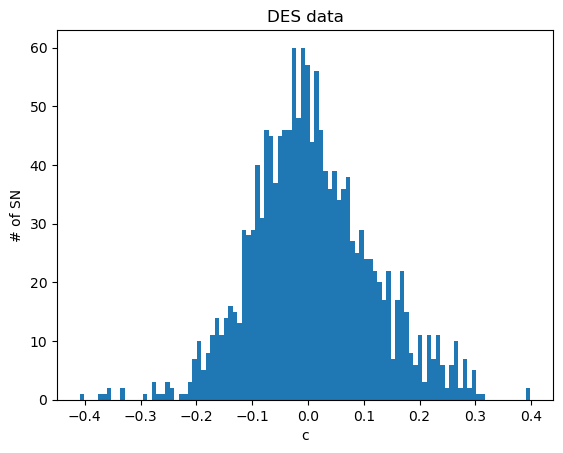

In [17]:
a, b, g = plt.hist(dropped_colors, bins=100)
plt.xlabel('c') 
plt.ylabel('# of SN') 
plt.title('DES data') 

In [19]:
dropped_colors[~np.isnan(dropped_colors)].min(), dropped_colors[~np.isnan(dropped_colors)].max()

(-0.409206, 0.39862)

In [23]:
cs_des = []
cs_des_means = []
zs_des = np.arange(0, 1.3, 0.1) 
# dropped_tnew['REDSHIFT_FINAL'].min(), dropped_tnew['REDSHIFT_FINAL'].max()

for i in range(len(zs_des) - 1): 
    cond1 = (zs_des[i] < dropped_tnew['REDSHIFT_FINAL'])
    cond2 = (dropped_tnew['REDSHIFT_FINAL'] <= zs_des[i+1])
    good_cs = dropped_colors[cond1 & cond2]
    cs_des.append(good_cs[~np.isnan(good_cs)])
    cs_des_means.append(good_cs[~np.isnan(good_cs)].mean())

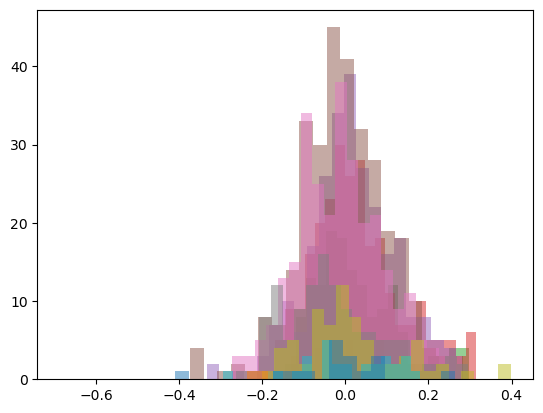

In [24]:
for i in range(len(cs_des)): 
    a, b, g = plt.hist(cs_des[i], bins=20, alpha=0.5)

In [23]:
cs_des_means
### so there is a selection bluing effect in observed colors as well! 

[0.14073123333333334,
 0.04046703772727273,
 0.028017993677999998,
 0.03130514473461538,
 0.016418475928853756,
 -0.005058303656765677,
 -0.011020764560283686,
 -0.024404809901639343,
 0.02006068687323944,
 0.012824577142857143,
 -0.016609767647058824,
 -0.186789]

Text(0.5, 1.0, 'DES color means $\\bar{c}$ vs. redshift $z$')

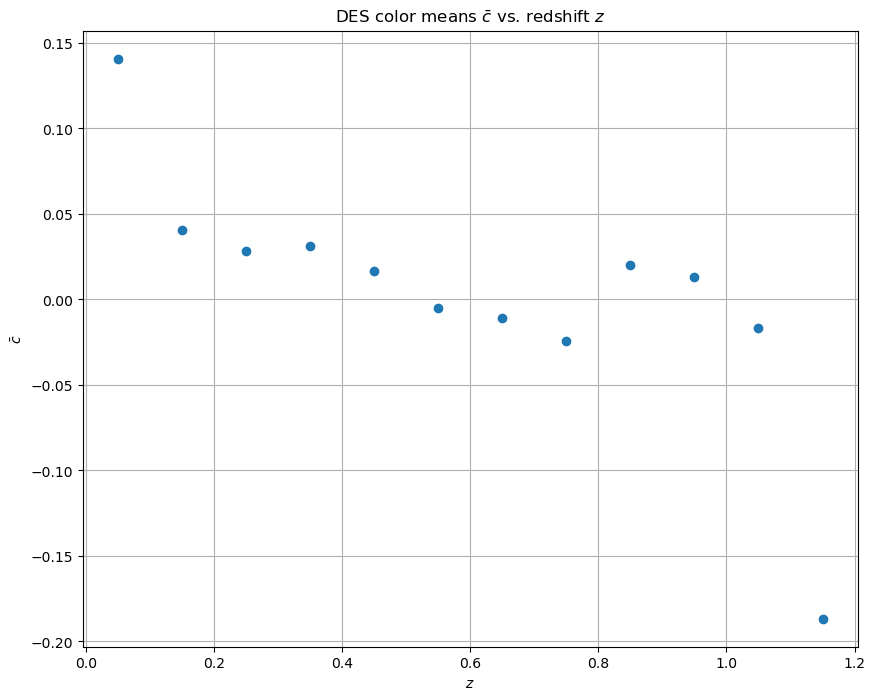

In [29]:
zbins = np.arange(0, 1.3, 0.1) 
zcenters = [0.5*(zbins[i] + zbins[i+1]) for i in range(len(zbins) - 1)]
cs_des_means = [0.14073123333333334,
 0.04046703772727273,
 0.028017993677999998,
 0.03130514473461538,
 0.016418475928853756,
 -0.005058303656765677,
 -0.011020764560283686,
 -0.024404809901639343,
 0.02006068687323944,
 0.012824577142857143,
 -0.016609767647058824,
 -0.186789]

plt.figure(figsize=(10,8))
plt.plot(zcenters, cs_des_means, 'o')
plt.xlabel('$z$') 
plt.ylabel(r'$\bar{c}$')
plt.grid()
plt.title(r'DES color means $\bar{c}$ vs. redshift $z$')

Text(0.5, 1.0, 'DES color means $\\bar{c}$ vs. redshift $z$')

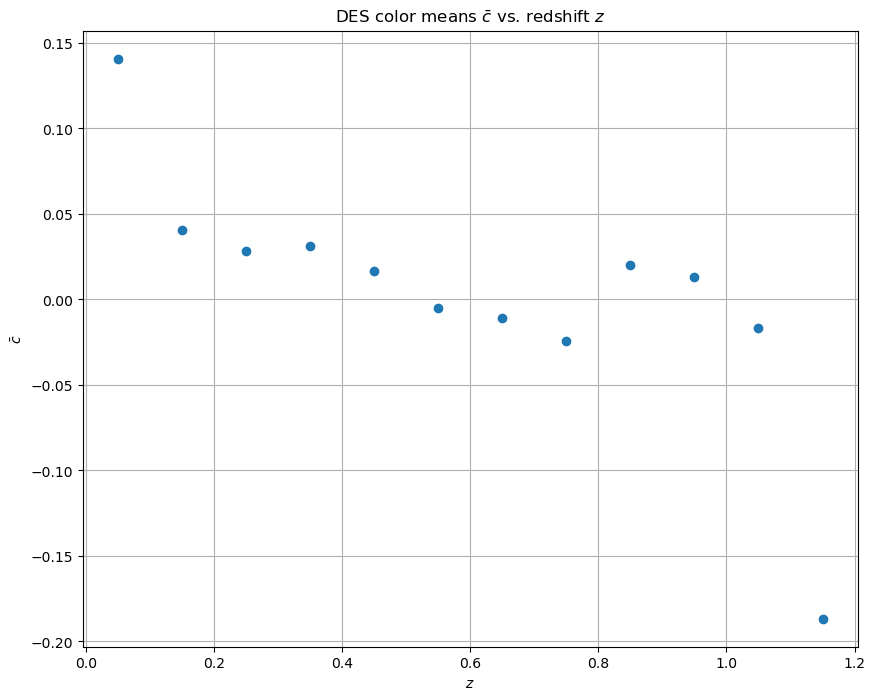

In [29]:
zbins = np.arange(0, 1.3, 0.1) 
zcenters = [0.5*(zbins[i] + zbins[i+1]) for i in range(len(zbins) - 1)]
cs_des_means = [0.14073123333333334,
 0.04046703772727273,
 0.028017993677999998,
 0.03130514473461538,
 0.016418475928853756,
 -0.005058303656765677,
 -0.011020764560283686,
 -0.024404809901639343,
 0.02006068687323944,
 0.012824577142857143,
 -0.016609767647058824,
 -0.186789]

plt.figure(figsize=(10,8))
plt.plot(zcenters, cs_des_means, 'o')
plt.xlabel('$z$') 
plt.ylabel(r'$\bar{c}$')
plt.grid()
plt.title(r'DES color means $\bar{c}$ vs. redshift $z$')

In [ ]:
### 1) try equal-sized bins (this will shift the redshift divide) 
### 2) try multiple redshift bins (>2) (like what i did above, but do this with sims as well & look at distribution, means) 
    #### modify this 
    #### a) note: i already looked at color vs. redshift (and bias-corrected color vs. redshift) for observed, but I haven't yet for the measured sims
    #### look at distribution as well 
### 3) Do this again for the bias-cor colors. (would this make sense though since sims aren't bias-corrected??) 

In [25]:
### 1) try equal-sized bins (this will shift the redshift divide) 

half = int(np.ceil((len(dropped_colors[np.argsort(dropped_tnew['REDSHIFT_FINAL'])])/2)))
c_lowz_des = dropped_colors[np.argsort(dropped_tnew['REDSHIFT_FINAL'])][:half]
c_highz_des = dropped_colors[np.argsort(dropped_tnew['REDSHIFT_FINAL'])][half:]

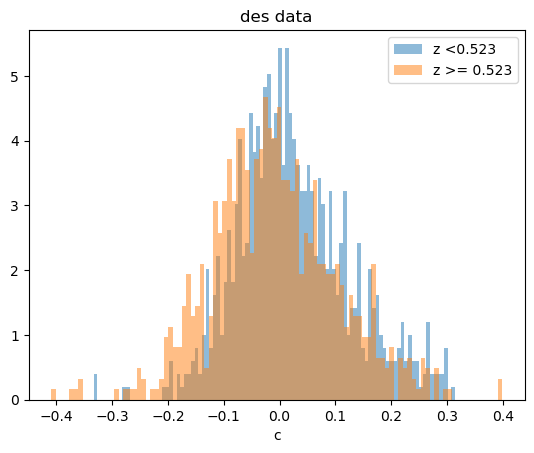

In [26]:
### 1) try equal-sized bins (this will shift the redshift divide) 
nonan_reds = dropped_tnew['REDSHIFT_FINAL'][~np.isnan(dropped_colors)]
nonan_colors = dropped_colors[~np.isnan(dropped_colors)]

half = int(np.ceil((len(nonan_colors) / 2)))
c_lowz_des = nonan_colors[np.argsort(nonan_reds)][:half]
c_highz_des = nonan_colors[np.argsort(nonan_reds)][half:]

avg_c_lowz_des = np.mean(c_lowz_des)
avg_c_highz_des = np.mean(c_highz_des)

#redshift divide 
red_div = (1/2) * (nonan_reds[np.argsort(nonan_reds)][:half][-1] + nonan_reds[np.argsort(nonan_reds)][half:][0])
# np.save('red_div', red_div)

a, b, g = plt.hist(c_lowz_des, bins=100, alpha=0.5, density=True, label=f'z <{red_div:.3f}')
a, b, g = plt.hist(c_highz_des, bins=100, alpha=0.5, density=True, label=f'z >= {red_div:.3f}')
plt.xlabel('c')
plt.title('des data')
plt.legend()

In [27]:
avg_c_lowz_des, avg_c_highz_des

(0.024450993596740547, -0.008290644302477184)

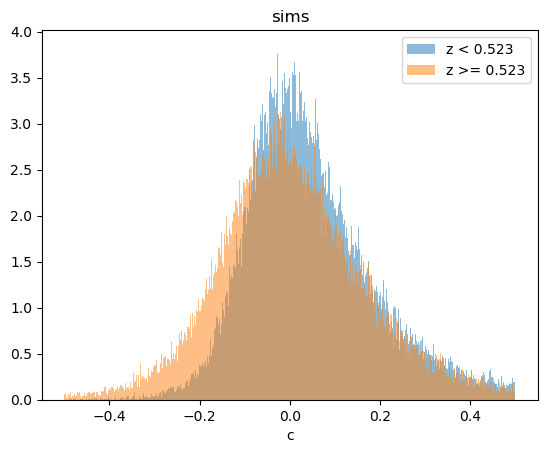

In [29]:
c_lowz_sim = np.load('c_lowz.npy')
avg_c_lowz_sim = np.mean(c_lowz_sim)
c_highz_sim = np.load('c_highz.npy')
avg_c_highz_sim = np.mean(c_highz_sim)

a, b, g = plt.hist(c_lowz_sim, bins=1000, alpha=0.5, density=True, label=f'z < {red_div:.3f}')
a, b, g = plt.hist(c_highz_sim, bins=1000, alpha=0.5, density=True, label=f'z >= {red_div:.3f}')
plt.xlabel('c')
plt.title('sims')
plt.legend()

In [30]:
avg_c_lowz_sim, avg_c_highz_sim

(0.04636846917619818, 0.005720260865722142)

In [31]:
## now let's look at significance for the new (equal) redshift divide case: 
print(avg_c_lowz_des, avg_c_highz_des)

print(avg_c_lowz_sim, avg_c_highz_sim)

0.024450993596740547 -0.008290644302477184
0.04636846917619818 0.005720260865722142


In [32]:
delta_eq = avg_c_lowz_sim - avg_c_lowz_des
print(avg_c_lowz_des + delta_eq, avg_c_highz_des + delta_eq)
print(avg_c_lowz_sim, avg_c_highz_sim)

0.04636846917619818 0.013626831276980446
0.04636846917619818 0.005720260865722142


In [33]:
np.std(c_lowz_des) / np.sqrt(len(c_lowz_des)), np.std(c_highz_des) / np.sqrt(len(c_highz_des))
np.std(c_lowz_sim) / np.sqrt(len(c_lowz_sim)), np.std(c_highz_sim) / np.sqrt(len(c_highz_sim))

# from scipy.stats import sem
# sem(c_highz_des)    # sample sig (so n-1 on bottom) 

(0.0004740320811844747, 0.00048479927676504486)

In [34]:
sig_eq = np.std(c_highz_des) / np.sqrt(len(c_highz_des))
sig_eq

0.004048358158347029

In [35]:
sig_eq = np.std(c_highz_des) / np.sqrt(len(c_highz_des))
(avg_c_highz_des + delta_eq - avg_c_highz_sim) / sig_eq       ### low sig 


1.9530313529588021

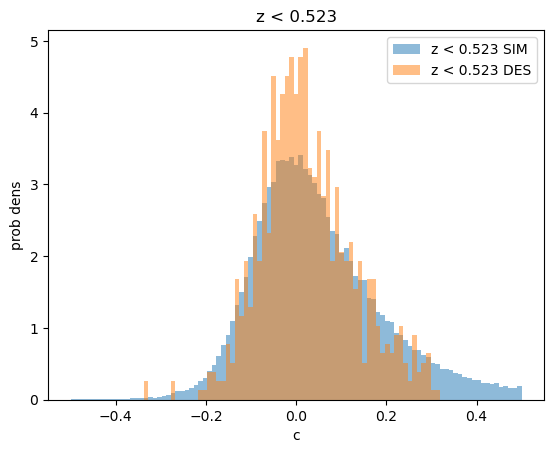

In [77]:
## distributions for 2-equal sized bins: 
bins = np.linspace(-0.5, 0.5, 100)
a, b, g = plt.hist(c_lowz_sim, bins=bins, alpha=0.5, density=True, label=f'z < {red_div:.3f} SIM')
a, b, g = plt.hist(c_lowz_des, bins=bins, alpha=0.5, density=True, label=f'z < {red_div:.3f} DES')
plt.xlabel('c')
plt.ylabel('prob dens')
plt.title(f'z < {red_div:.3f}')
plt.legend()

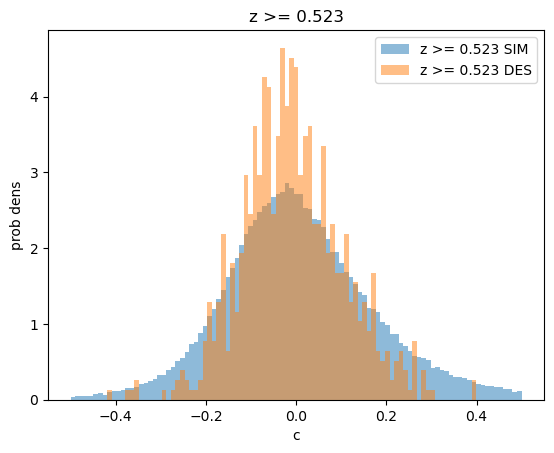

In [78]:
bins = np.linspace(-0.5, 0.5, 100)
a, b, g = plt.hist(c_highz_sim, bins=bins, alpha=0.5, density=True, label=f'z >= {red_div:.3f} SIM')
a, b, g = plt.hist(c_highz_des, bins=bins, alpha=0.5, density=True, label=f'z >= {red_div:.3f} DES')
plt.xlabel('c')
plt.ylabel('prob dens')
plt.title(f'z >= {red_div:.3f}')
plt.legend()

In [22]:
nonan_reds = dropped_tnew['REDSHIFT_FINAL'][~np.isnan(dropped_colors)]
nonan_colors = dropped_colors[~np.isnan(dropped_colors)]

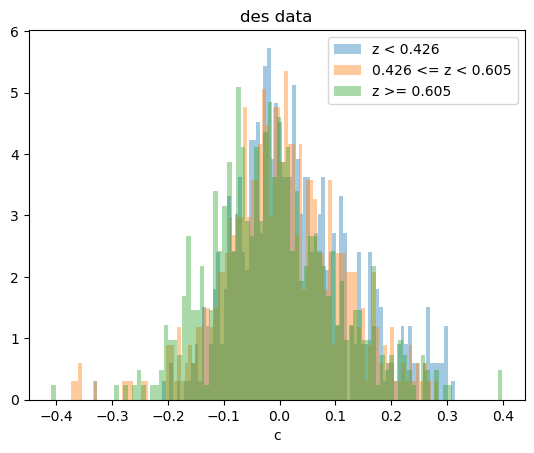

In [208]:
### Now, for 3 equal-sized bins: (maybe try up to like 6) 

t1 = int(np.ceil((len(nonan_colors) / 3)))
t2 = int(np.ceil(2 * (len(nonan_colors) / 3)))
c_z1_des = nonan_colors[np.argsort(nonan_reds)][:t1]
c_z2_des = nonan_colors[np.argsort(nonan_reds)][t1:t2]
c_z3_des = nonan_colors[np.argsort(nonan_reds)][t2:]

avg_c_z1_des = np.mean(c_z1_des)
avg_c_z2_des = np.mean(c_z2_des)
avg_c_z3_des = np.mean(c_z3_des)

#redshift divide 
red_div1 = (1/2) * (nonan_reds[np.argsort(nonan_reds)][:t1][-1] + nonan_reds[np.argsort(nonan_reds)][t1:t2][0])
red_div2 = (1/2) * (nonan_reds[np.argsort(nonan_reds)][t1:t2][-1] + nonan_reds[np.argsort(nonan_reds)][t2:][0])

a, b, g = plt.hist(c_z1_des, bins=100, alpha=0.4, density=True, label=f'z < {red_div1:.3f}')
a, b, g = plt.hist(c_z2_des, bins=100, alpha=0.4, density=True, label=f'{red_div1:.3f} <= z < {red_div2:.3f}')
a, b, g = plt.hist(c_z3_des, bins=100, alpha=0.4, density=True, label=f'z >= {red_div2:.3f}')
plt.xlabel('c')
plt.title('des data')
plt.legend()


In [24]:
(avg_c_z1_des, avg_c_z2_des, avg_c_z3_des)

(0.028186770286523437, 0.005290860191780823, -0.009276454082191781)

Text(0.5, 0, 'c')

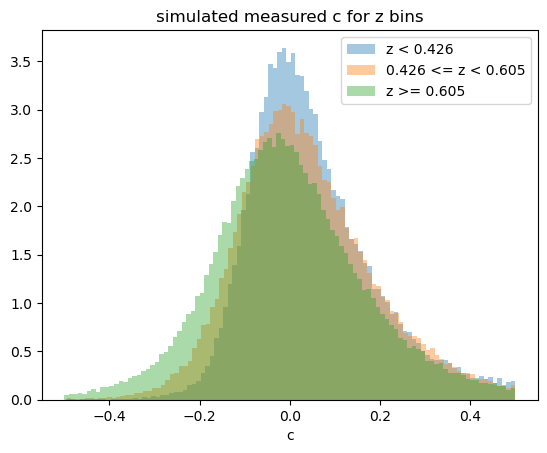

In [28]:
c_z1_sim = np.load('c_z1.npy')
avg_c_z1_sim = np.mean(c_z1_sim)
c_z2_sim = np.load('c_z2.npy')
avg_c_z2_sim = np.mean(c_z2_sim)
c_z3_sim = np.load('c_z3.npy')
avg_c_z3_sim = np.mean(c_z3_sim)

a, b, g = plt.hist(c_z1_sim, bins=100, alpha=0.4, density=True, label=f'z < {red_div1:.3f}')
a, b, g = plt.hist(c_z2_sim, bins=100, alpha=0.4, density=True, label=f'{red_div1:.3f} <= z < {red_div2:.3f}')
a, b, g = plt.hist(c_z3_sim, bins=100, alpha=0.4, density=True, label=f'z >= {red_div2:.3f}')
## note there are more at high redshift (density=False) 

plt.legend()
plt.title('simulated measured c for z bins') 
plt.xlabel('c')


Text(0.5, 1.0, 'simulated measured c for z bins')

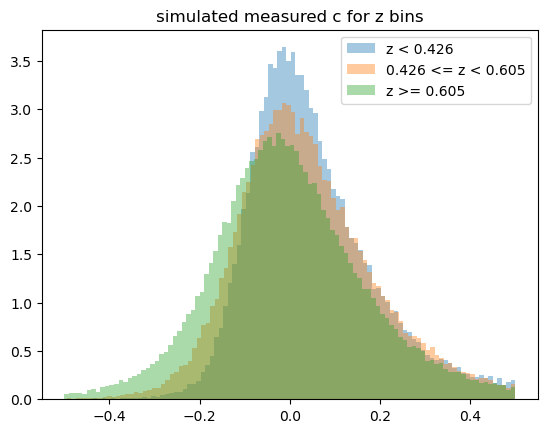

In [49]:
c_z1_sim = np.load('c_z1.npy')
avg_c_z1_sim = np.mean(c_z1_sim)
c_z2_sim = np.load('c_z2.npy')
avg_c_z2_sim = np.mean(c_z2_sim)
c_z3_sim = np.load('c_z3.npy')
avg_c_z3_sim = np.mean(c_z3_sim)

a, b, g = plt.hist(c_z1_sim, bins=100, alpha=0.4, density=True, label=f'z < {red_div1:.3f}')
a, b, g = plt.hist(c_z2_sim, bins=100, alpha=0.4, density=True, label=f'{red_div1:.3f} <= z < {red_div2:.3f}')
a, b, g = plt.hist(c_z3_sim, bins=100, alpha=0.4, density=True, label=f'z >= {red_div2:.3f}')
## note there are more at high redshift (density=False) 

plt.legend()
plt.title('simulated measured c for z bins') 
plt.xlabel('c')


In [26]:
(avg_c_z1_sim, avg_c_z2_sim, avg_c_z3_sim)

(0.048728843616890775, 0.03510155909704673, -0.0028179530644392085)

In [41]:
(avg_c_z1_des, avg_c_z2_des, avg_c_z3_des)

(0.028186770286523437, 0.005290860191780823, -0.009276454082191781)

In [42]:
sig1_des = np.std(c_z1_des) / np.sqrt(len(c_z1_des))
sig2_des = np.std(c_z2_des) / np.sqrt(len(c_z2_des))
sig3_des = np.std(c_z3_des) / np.sqrt(len(c_z3_des))

sig1_sim = np.std(c_z1_sim) / np.sqrt(len(c_z1_sim))
sig2_sim = np.std(c_z2_sim) / np.sqrt(len(c_z2_sim))
sig3_sim = np.std(c_z3_sim) / np.sqrt(len(c_z3_sim))

In [43]:
delta1 = avg_c_z1_sim - avg_c_z1_des
delta2 = avg_c_z2_sim - avg_c_z2_des 
delta3 = avg_c_z3_sim - avg_c_z3_des 

## detection in 2nd red bin
(avg_c_z2_des + delta1 - avg_c_z2_sim) / sig2_des   # rip it's negative 


## detection in 3rd red bin 
(avg_c_z3_des + delta2 - avg_c_z3_sim) / sig3_des    ## but huge detection in HIGHER REDSHIFT. 

4.683743409063194

In [71]:
(avg_c_z2_des + delta1 - avg_c_z2_sim) / sig2_des

-1.984706339210248

In [72]:
(avg_c_z3_des + delta2 - avg_c_z3_sim) / sig3_des

4.683743409063194

In [44]:
(avg_c_z1_des + delta1, avg_c_z2_des + delta1, avg_c_z3_des + delta1)

(0.048728843616890775, 0.02583293352214816, 0.011265619248175558)

In [45]:
(avg_c_z1_sim, avg_c_z2_sim, avg_c_z3_sim)

(0.048728843616890775, 0.03510155909704673, -0.0028179530644392085)

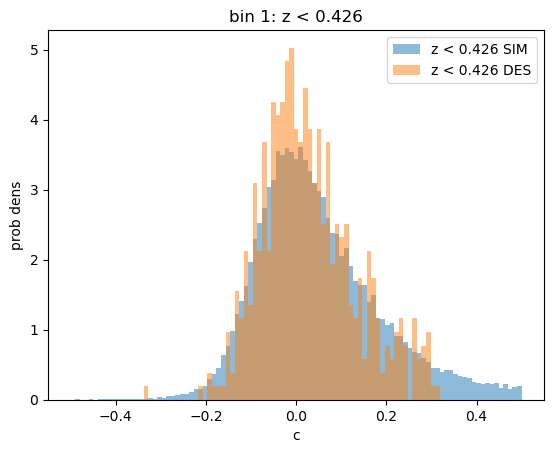

In [68]:
### plot distributions of des vs. sims 
bins = np.linspace(-0.5, 0.5, 100)
a, b, g = plt.hist(c_z1_sim, bins=bins, alpha=0.5, density=True, label=f'z < {red_div1:.3f} SIM')
a, b, g = plt.hist(c_z1_des, bins=bins, alpha=0.5, density=True, label=f'z < {red_div1:.3f} DES')
plt.xlabel('c')
plt.ylabel('prob dens')
plt.title(f'bin 1: z < {red_div1:.3f}')
plt.legend()

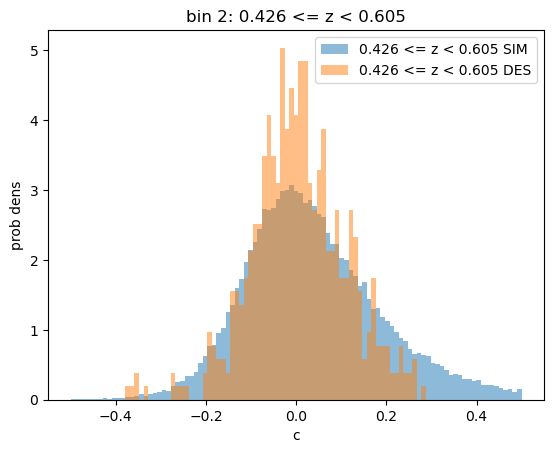

In [69]:
### plot distributions of des vs. sims 
bins = np.linspace(-0.5, 0.5, 100)
a, b, g = plt.hist(c_z2_sim, bins=bins, alpha=0.5, density=True, label=f'{red_div1:.3f} <= z < {red_div2:.3f} SIM')
a, b, g = plt.hist(c_z2_des, bins=bins, alpha=0.5, density=True, label=f'{red_div1:.3f} <= z < {red_div2:.3f} DES')
plt.xlabel('c')
plt.ylabel('prob dens')
plt.title(f'bin 2: {red_div1:.3f} <= z < {red_div2:.3f}')
plt.legend()

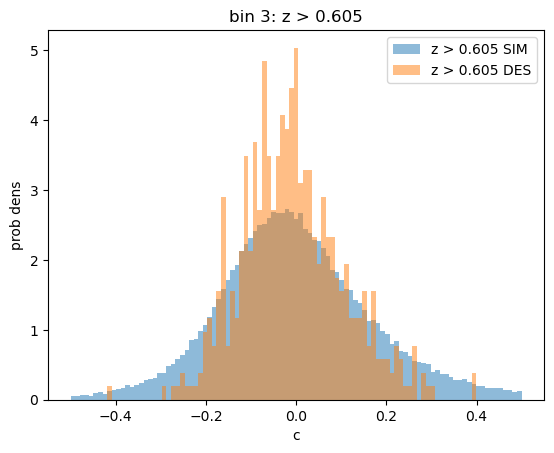

In [70]:
bins = np.linspace(-0.5, 0.5, 100)
a, b, g = plt.hist(c_z3_sim, bins=bins, alpha=0.5, density=True, label=f'z > {red_div2:.3f} SIM')
a, b, g = plt.hist(c_z3_des, bins=bins, alpha=0.5, density=True, label=f'z > {red_div2:.3f} DES')
plt.xlabel('c')
plt.ylabel('prob dens')
plt.title(f'bin 3: z > {red_div2:.3f}')
plt.legend()

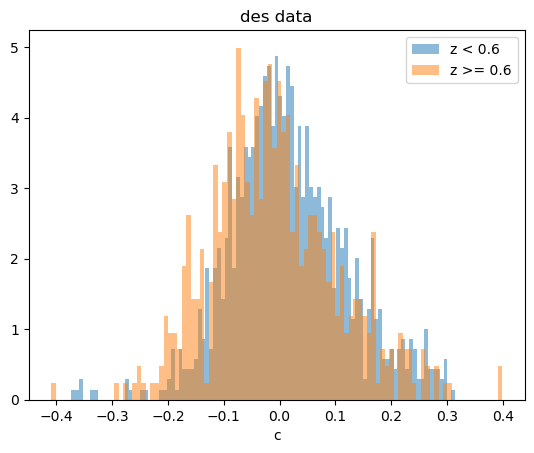

In [20]:
### original splitting into two bins (redshift divide picked arbitrarily) 
c_smallz_des = dropped_colors[dropped_tnew['REDSHIFT_FINAL'] < 0.6]
c_smallz_des = c_smallz_des[~np.isnan(c_smallz_des)]
avg_c_small_z_des = np.mean(c_smallz_des[~np.isnan(c_smallz_des)])
c_largez_des = dropped_colors[dropped_tnew['REDSHIFT_FINAL'] >= 0.6]
c_largez_des = c_largez_des[~np.isnan(c_largez_des)]
avg_c_large_z_des = np.mean(c_largez_des[~np.isnan(c_largez_des)])
a, b, g = plt.hist(c_smallz_des, bins=100, alpha=0.5, density=True, label='z < 0.6')
a, b, g = plt.hist(c_largez_des, bins=100, alpha=0.5, density=True, label='z >= 0.6')
plt.xlabel('c')
plt.title('des data')
plt.legend()

In [21]:
avg_c_small_z_des, avg_c_large_z_des

(0.016945694417275416, -0.009157390664107486)

In [22]:
c_smallz_des.min(), c_smallz_des.max()
c_largez_des.min(), c_largez_des.max()

(-0.409206, 0.39862)

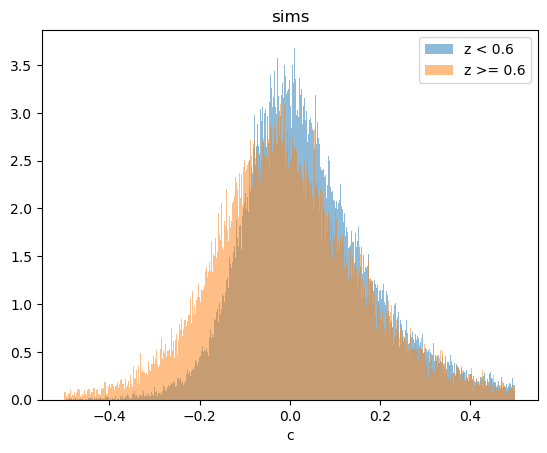

In [23]:
c_small_z_sim = np.load('c_small_z.npy')
avg_c_small_z_sim = np.mean(c_small_z_sim)
c_large_z_sim = np.load('c_large_z.npy')
avg_c_large_z_sim = np.mean(c_large_z_sim)

a, b, g = plt.hist(c_small_z_sim, bins=1000, alpha=0.5, density=True, label='z < 0.6')
a, b, g = plt.hist(c_large_z_sim, bins=1000, alpha=0.5, density=True, label='z >= 0.6')
plt.xlabel('c')
plt.title('sims')
plt.legend()


In [51]:
avg_c_small_z_sim, avg_c_large_z_sim

(0.041955568398924156, -0.002454131261670543)

In [74]:
c_small_z_sim.min(), c_small_z_sim.max()

(-0.496183, 0.5)

In [75]:
c_large_z_sim.min(), c_large_z_sim.max()

(-0.499853, 0.49999)

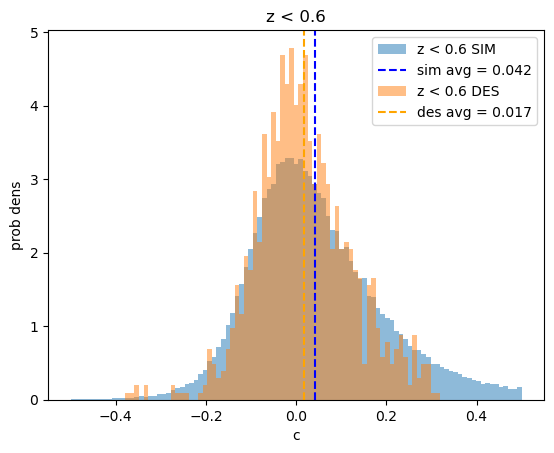

In [73]:
## bin them in the same manner (i.e. same bins, and then count, and then subtract)
bins = np.linspace(-0.5, 0.5, 100)
plt.hist(c_small_z_sim, bins=bins, alpha=0.5, density=True, label='z < 0.6 SIM')
plt.axvline(avg_c_small_z_sim, color='blue', ls='--', label=f'sim avg = {avg_c_small_z_sim:.3f}')
plt.hist(c_smallz_des, bins=bins, alpha=0.5, density=True, label='z < 0.6 DES')
plt.axvline(avg_c_small_z_des, color='orange', ls='--', label=f'des avg = {avg_c_small_z_des:.3f}')
plt.xlabel('c')
plt.ylabel('prob dens')
plt.title('z < 0.6')
plt.legend()

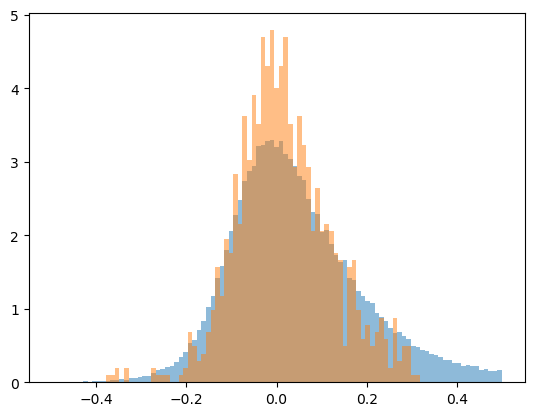

In [121]:
n_smallz_sim, g, h = plt.hist(c_small_z_sim, bins=bins, alpha=0.5, density=True, label='z < 0.6 SIM')
n_smallz_des, g, h = plt.hist(c_smallz_des, bins=bins, alpha=0.5, density=True, label='z < 0.6 DES')

Text(0.5, 1.0, 'z<0.6')

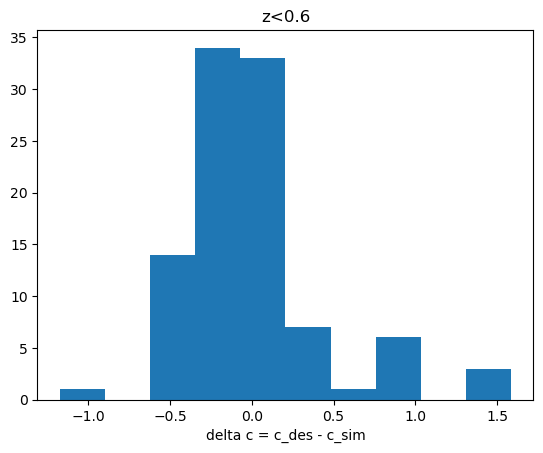

In [129]:
plt.hist(n_smallz_des - n_smallz_sim, bins=10)
plt.xlabel('delta c = c_des - c_sim')
plt.title('z<0.6')

In [80]:
len(c_smallz_des), len(c_largez_des)

(1013, 521)

In [ ]:
## move so both bins have equal size 
    # shift redshift divide (maybe change significance slightly) 

## try more redshift bins (maybe 3?) 

## look at distribution as well 

In [71]:
np.std(c_smallz_des) / np.sqrt(len(c_smallz_des)), np.std(c_largez_des) / np.sqrt(len(c_largez_des))

(0.0033112512254785402, 0.004953258854726814)

In [74]:
np.std(c_small_z_sim) / np.sqrt(len(c_small_z_sim)), np.std(c_large_z_sim) / np.sqrt(len(c_large_z_sim))


(0.0004178097576604621, 0.000576507449531117)

In [91]:
avg_c_small_z_des, avg_c_large_z_des

(0.016945694417275416, -0.009157390664107486)

In [77]:
delta = avg_c_small_z_sim - avg_c_small_z_des
avg_c_small_z_des + delta , avg_c_large_z_des + delta 

(0.041955568398924156, 0.015852483317541254)

In [67]:
avg_c_small_z_sim, avg_c_large_z_sim

(0.041955568398924156, -0.002454131261670543)

In [79]:
sig = np.std(c_largez_des) / np.sqrt(len(c_largez_des))
(avg_c_large_z_des + delta - avg_c_large_z_sim) / sig

3.695872781157418

In [ ]:
avg_c_small_z_sim -avg_c_small_z_des , avg_c_large_z_sim-avg_c_small_z_des

In [96]:
avg_c_small_z_sim, avg_c_small_z_des

(0.041955568398924156, 0.016945694417275416)

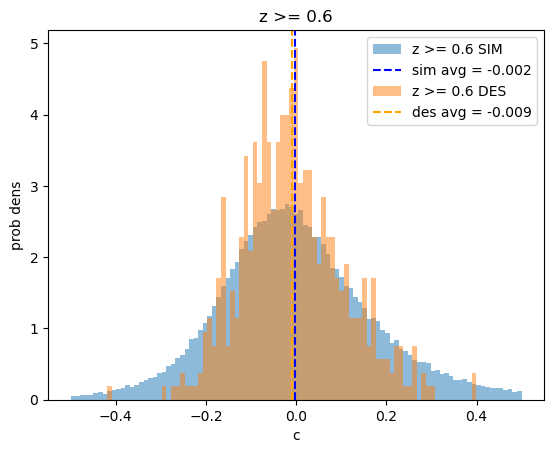

In [115]:
bins = np.linspace(-0.5, 0.5, 100)
plt.hist(c_large_z_sim, bins=bins, alpha=0.5, density=True, label='z >= 0.6 SIM')
plt.axvline(avg_c_large_z_sim, color='blue', ls='--', label=f'sim avg = {avg_c_large_z_sim:.3f}')
plt.hist(c_largez_des, bins=bins, alpha=0.5, density=True, label='z >= 0.6 DES')
plt.axvline(avg_c_large_z_des, color='orange', ls='--', label=f'des avg = {avg_c_large_z_des:.3f}')

plt.xlabel('c')
plt.ylabel('prob dens')
plt.title('z >= 0.6')
plt.legend()


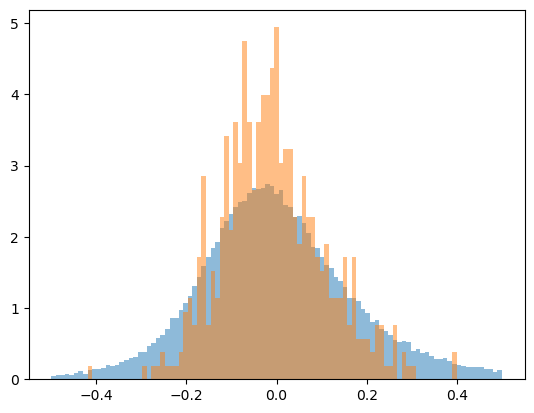

In [130]:
n_largez_sim, g, h = plt.hist(c_large_z_sim, bins=bins, alpha=0.5, density=True, label='z < 0.6 SIM')
n_largez_des, g, h = plt.hist(c_largez_des, bins=bins, alpha=0.5, density=True, label='z < 0.6 DES')

Text(0.5, 1.0, 'z >= 0.6')

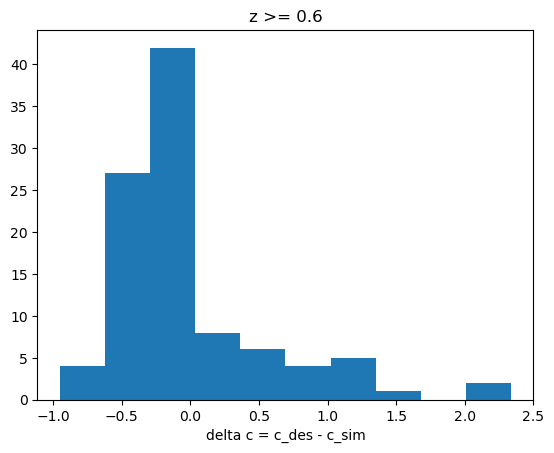

In [131]:
plt.hist(n_largez_des - n_largez_sim, bins=10)
plt.xlabel('delta c = c_des - c_sim')
plt.title('z >= 0.6')

In [95]:
avg_c_large_z_sim, avg_c_large_z_des

(-0.002454131261670543, -0.009157390664107486)

# II. Bulk: 1) Calculating $r_{eff}$, 2) Calculating $N_H$

## 1. Calculating $r_{eff}$

In [17]:
import os

# sn index number i (from 0 to 1543 now) 
# dropped sn: 1543, dropped_df: 4179372

# z, ra, dec of all galaxies
gal_ztrue = new_dropped_df['ZTRUE'].values
gal_ra = new_dropped_df['RA_GAL'].values * u.deg
gal_dec = new_dropped_df['DEC_GAL'].values * u.deg
gal_angdist_all = cosmo.angular_diameter_distance(gal_ztrue)

num_fgals = np.full(len(dropped_tnew['CID'].data), np.nan)

close_imp_bins = np.load('imp_bins_first500_close.npy') 

thresh = 1000      # in kpc, REDUCE THE SEARCH RADIUS! 

def process_chunk_dropped(start_idx, end_idx, host=False):
    
    all_imp_kpcs2_internal = np.zeros((len(dropped_tnew['CID'].data), len(dropped_df)))   
    
    for i in tqdm(range(start_idx, end_idx), total=end_idx - start_idx):
        cid = dropped_tnew['CID'].data[i]
        z_sn = dropped_tnew[i]['REDSHIFT_FINAL']
        ra_sn = dropped_tnew[i]['RA'] * u.deg
        dec_sn = dropped_tnew[i]['DEC'] * u.deg
        
        sn_angdist = cosmo.angular_diameter_distance(z_sn)       # actually not needed
        sn_coord = SkyCoord(ra=ra_sn, dec=dec_sn, distance=sn_angdist)

        mask = (new_dropped_df['ZTRUE'] <= z_sn)     # len 4179372

        hostgal_match = np.where(new_dropped_df['GALID'] == dropped_hostgal_big_is_galids[i])[0]   
        ### ^ NOTE ON THIS! IT IS THE ROW NUMBER IN THE DROPPED DF, BUT WILL FAIL WITH .LOC DUE TO THE EXTRA COLUMN OF THE ORIGINAL DF INDEX ###. 
        ### ALSO ANOTHER NOTE: (in general) loc uses the label of the dataframe to locate row, while iloc uses the actual number index.

        # assertion here for sn, hostgal_fromsn, and hostgal_fromgal ra, dec, redshifts. 
        assert np.isclose(gal_ra.value[hostgal_match][0], dropped_tnew[i]['HOSTGAL_RA'], 0.002)
        assert np.isclose(gal_dec.value[hostgal_match][0], dropped_tnew[i]['HOSTGAL_DEC'], 0.002)

        # assertion will fail for the specz's for hostgal from sn = 0 (pathological) 
        dropped_specz_0 = np.where(dropped_tnew['HOSTGAL_SPECZ'] == 0)[0]      # <-  indices changed from tnew
        if np.isin(i, dropped_specz_0) == False: 
            assert np.isclose(gal_ztrue[hostgal_match][0], dropped_tnew[i]['HOSTGAL_SPECZ'], atol=0.02) 

        if host == False:   
            mask[hostgal_match] = False

        if host == True: 
            mask[hostgal_match] = True

        gal_coords = SkyCoord(ra=gal_ra[mask], dec=gal_dec[mask], distance=gal_angdist_all[mask])

        thetas = sn_coord.separation(gal_coords).radian
        

        #### 2nd way of projection (right triangle, 2D geometry) -- gives smaller values of impact parameter
        imp_kpc_2 = (gal_angdist_all[mask].to(u.kpc) * np.sin(thetas)).value
        imp_kpc_2[imp_kpc_2 == 0] = -1 
        all_imp_kpcs2_internal[i, mask] = imp_kpc_2   

        # then replace the -1 with the *CORRECT* 0 kpc values.
        all_imp_kpcs2_internal[i][all_imp_kpcs2_internal[i] == 0] = -100   # this is BACKGROUND GALAXIES (which aren't counted)  
        all_imp_kpcs2_internal[i][all_imp_kpcs2_internal[i] == -1] = 0     # now, account for the gals that actually have a b of 0

        
        # Save to file while doing this so it doesn't completely crash
        if host == False: 
            imp_name = 'ImParams_RT_no_host'
            gal_name = 'CloseGal_RT_no_host'
        if host == True: 
            imp_name = 'ImParams_RT_host'
            gal_name = 'CloseGal_RT_host'
            
        if os.path.exists(f'{imp_name}') == False: 
            os.system(f'mkdir {imp_name}')
        np.save(f'/pscratch/sd/j/joygong/Dust/{imp_name}/all_imp_kpcs2_SN_{i}', all_imp_kpcs2_internal[i])
    
        # Get indexes of close galaxies for weighting purposes later. 
        close_gal = (0 <= all_imp_kpcs2_internal[i]) & (all_imp_kpcs2_internal[i] < thresh) 
        
        if os.path.exists(f'{gal_name}') == False: 
            os.system(f'mkdir {gal_name}')
        np.save(f'/pscratch/sd/j/joygong/Dust/{gal_name}/close_gals_SN_{i}', close_gal)   #, overwrite='True')
        
        if os.path.exists('Dropped_HostGal_Match') == False: 
            os.system('mkdir Dropped_HostGal_Match')
        np.save(f'/pscratch/sd/j/joygong/Dust/Dropped_HostGal_Match/hostgal_match_{i}', np.array(hostgal_match))   #, overwrite='True')
        

In [ ]:
## run in chunks
chunk_size = 500 
num_chunks = int(np.ceil(len(dropped_tnew['CID'].data) / chunk_size)) 

for chunk in range(3, 4):     
    start_idx = chunk * chunk_size 
    end_idx = min((chunk + 1) * chunk_size, len(dropped_tnew['CID'].data))  
    process_chunk_dropped(start_idx, end_idx, host=False)
    
    print(f'Done with chunk {chunk}!') 


In [43]:
## check to see if need to run everyting again, or can use the stuff that i currently have & just modify closegal

np.load('/pscratch/sd/j/joygong/Dust/ImParams_RT_no_host/all_imp_kpcs2_SN_365.npy')


array([-1.00000000e+02, -1.00000000e+02,  4.80070445e+05, ...,
       -1.00000000e+02, -1.00000000e+02, -1.00000000e+02])

In [48]:
np.load('/pscratch/sd/j/joygong/Dust/CloseGal_RT_no_host/close_gals_SN_365.npy')

array([False, False, False, ..., False, False, False])

In [55]:
test_imps = np.load('/pscratch/sd/j/joygong/Dust/ImParams_RT_no_host/all_imp_kpcs2_SN_365.npy')
test_imps[test_imps > 0]

array([480070.44468442, 477657.48616679, 728418.71874933, ...,
       881890.27903847, 643634.6751811 , 592336.37637973])

In [60]:
new_thresh = 100
cond1 = (0 <= test_imps) & (test_imps < new_thresh) 

In [61]:
thresh = 1000
cond2 = (0 <= test_imps) & (test_imps < thresh) 

In [63]:
# np.where(cond1 != cond2)

(array([  62042,  159135,  205625,  298277,  303923,  304961,  363371,
         382863,  388604,  418028,  454763,  528448,  540654,  633278,
         742223, 1007670, 1074671, 1109609, 1194915, 1245908, 1538258,
        1558421, 1760301, 1805550, 1872130, 2002549, 2044217, 2293099,
        2366297, 2407417, 2420092, 2492785, 2572724, 2675809, 2684182,
        2692258, 2745889, 2844466, 2910030, 2913812, 2958805, 3418935,
        3421866, 3437680, 3438859, 3439346, 3439932, 3440427, 3440690,
        3440738, 3441367, 3441552, 3442225, 3444004, 3444420, 3445434,
        3448459, 3448547, 3477348, 3480406, 3495871, 3495943, 3496311,
        3496420, 3497159, 3497775, 3497959, 3498697, 3498777, 3498812,
        3498832, 3499204, 3499666, 3499859, 3499877, 3500458, 3500592,
        3501554, 3501744, 3501892, 3511020, 3511954, 3512033, 3512262,
        3512323, 3512371, 3513289, 3513300, 3515094, 3515261, 3537224,
        3541769, 3542008, 3586836, 3602205, 3602630, 3602654, 3602684,
      

## 2. Calculating $N_H$

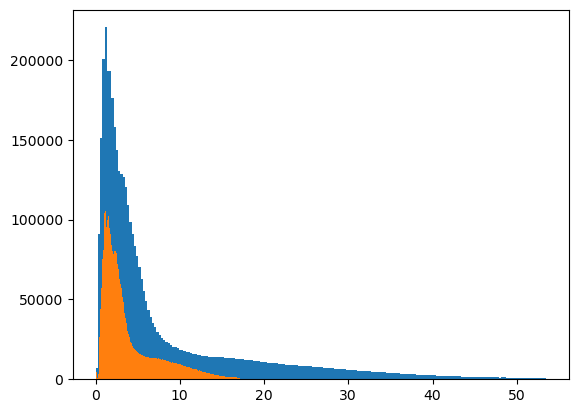

In [18]:
## superlinear relationship between sfr and gas

a, d, c = plt.hist(np.exp(new_dropped_df['LOG_SFR']), bins=200)
a, d, c = plt.hist(np.exp(new_dropped_df['LOG_SFR'])**(1/1.4), bins=200)

In [19]:
import scipy.integrate as sci

# half light radius R_e (from Helen's paper), in sersic profile 
# half light radius of milky way = 5.75 ± 0.38 kpc, from https://arxiv.org/html/2406.05604v1#:~:text=With%20the%20luminosity%20surface%20density,of%205.75%20%C2%B1%200.38%20kpc.
R_e = np.sqrt(new_dropped_df['a0_Sersic'] * new_dropped_df['b0_Sersic'])
R_e_weights = R_e / np.median(R_e)     # note milky way is medium-sized galaxy, but unsure what units the ab are in helen's df
    
# re-weight brightness according to median (assuming MW is average brightness)
mag_weights = 1 / (new_dropped_df['griz'] / new_dropped_df['griz'].median())    # 1 / because lower value = brighter 
    
# sfr weights 
sfr = np.exp(new_dropped_df['LOG_SFR'])
sfr_ks = np.exp(new_dropped_df['LOG_SFR'])**(1/1.4)
## note milky way is actually fairly high (6-7 / yr); is a spiral too
# mw_sfr = np.digitize(6.5, d) ## --> 25; assign weight of 1

mw_sfr_ks = np.digitize(6.5**(1/1.4), d)
# sfr_binsize = 1 / (mw_sfr)
sfr_binsize = 1 / (mw_sfr_ks)
# sfr_weights = np.digitize(sfr, d, right=False) * sfr_binsize 
sfr_weights = np.digitize(sfr_ks, d, right=False) * sfr_binsize 


# define function to calculate n_H value
def n_H(R, mag_weight, R_e_weight, sfr_weight): 
    """ 
    Average midplane volumn density as a function of R
    input: R, mag_weight (brightness weighting), R_e_weight (effective radius weighting) 
    output: n_H at radius R
    fiducial values for Milky Way: n(R, z0) ∼ n0 · e−(R−R_sun)/Rn with n0 = 0.9 cm−3 and Rn = 3.15 kpc.
    """ 
    # R_sun = (c.R_sun).to(u.kpc)               # NOTE: R_sun is NOT the radius of the sun, but the radius of sun from center of galaxy
    R_sun = 8.0                               # sun is ~8 kpc from center of mw                  
    n0_fid = 0.9                              # cm^-3 
    n0 = n0_fid * mag_weight * sfr_weight     # n_0 at R_n (n_0 proportional to the amount of gas / mass in galaxy) -> brightness
    R_n_fid = 3.15                            # kpc
    R_n = R_n_fid * R_e_weight                # R_n scaled by size of galaxy: a0_sersic, b0_sersic 
    
    return n0 * np.exp(-(R - R_sun)/R_n)      # R_sun in kpc, n0 (and n_H) in cm^-3 


# numerically integrate. [choose step size] (might be wayyy too slow esp for every galaxy) 
def num_integral(ys, xs): 
    """
    input: array of Rs (x-axis), array of n_Hs (y-axis)
    output: integral of n_H from R_min to R_max 
    """ 
    return sci.cumtrapz(ys, xs)
    ## make sure to do b -> 1000, and then *2
    
# analytical integral 
def ana_integral(R_min, R_max, mag_weight, R_e_weight, sfr_weight): 
    """ 
    Column density = integrated number density n_H
    inputs: R_min (cm), R_max (cm), mag_weight, R_e_weight 
    NOTE! All distance units need to be in cm 
    """ 
    R_sun = (8.0*u.kpc).to(u.cm).value        # sun is ~8 kpc from center of mw                  
    n0_fid = 0.9                              # cm^-3 
    n0 = n0_fid * mag_weight * sfr_weight     # n_0 at R_n (n_0 proportional to the amount of gas / mass in galaxy) -> brightness
    R_n_fid = (3.15*u.kpc).to(u.cm).value     # in cm (converted from kpc)
    R_n = R_n_fid * R_e_weight                # R_n scaled by size of galaxy: a0_sersic, b0_sersic 
    
    def indef(R): 
        return -n0 * R_n * np.exp(-(R - R_sun)/R_n)
    
    return indef(R_max) - indef(R_min)

In [28]:
## for every supernova: 
    ## do for all close foreground galaxies, then sum 

## selection based on z confidence 
z_ratio = new_dropped_df['ZERR']/new_dropped_df['ZTRUE']
z_sn_gr5 = z_ratio[z_ratio<0.2]
z_sn_gr5_cond = (z_ratio<0.2)
high_nh = np.array([3454528, 4004537])

def summed_column_density(i, host=False, high=False): 
    """
    input: i (SN index)
    output: summed column density of all close foreground galaxies to SN 
    """
    thresh = 1000        # kpc <- change to 100? 
    
    if host == False: 
        imp_name = 'ImParams_RT_no_host'
        close_gal_name = 'CloseGal_RT_no_host'
    if host == True: 
        imp_name = 'ImParams_RT_host'
        close_gal_name = 'CloseGal_RT_host'
        
    all_imps = np.load(f'/pscratch/sd/j/joygong/Dust/{imp_name}/all_imp_kpcs2_SN_{i}.npy')
    close_gs = np.load(f'/pscratch/sd/j/joygong/Dust/{close_gal_name}/close_gals_SN_{i}.npy')
    hostgal = np.load(f'/pscratch/sd/j/joygong/Dust/Dropped_HostGal_Match/hostgal_match_{i}.npy')

        
    ## add in good z selection here 
    cond = (close_gs) & (z_sn_gr5_cond)
    if high == False: 
        if (cond[high_nh[0]] == True) or (cond[high_nh[1]] == True): 
            cond[high_nh[0]] = False
            cond[high_nh[1]] = False
            
    close_imps = all_imps[cond]
    close_mag_weights = mag_weights.values[cond]
    close_R_e_weights = R_e_weights.values[cond]
    close_sfr_weights = sfr_weights[cond]
    
    col_dens = np.zeros(len(close_imps))
    
    for i in range(len(col_dens)): 
        col_dens[i] = 2 * ana_integral((close_imps[i]*u.kpc).to(u.cm).value, (thresh*u.kpc).to(u.cm).value, close_mag_weights[i], close_R_e_weights[i], close_sfr_weights[i])

    ### sum over all contributions 
    col_sum = np.sum(col_dens)

    return col_sum, col_dens, close_imps, cond    # last is the cond (close_gs) & (z_sn_gr5_cond) & high_nh false stuff

In [29]:
### save the individual arrays for n_h contribution for EACH SN & the (close_gs) & (z_sn_gr5_cond) for EACH SN
all_nh_sn = [[] for _ in range(len(dropped_tnew))]
all_close_cond_sn = [[] for _ in range(len(dropped_tnew))]

for i in tqdm(range(len(dropped_tnew))): 
    res = summed_column_density(i, host=False, high=False)
    all_nh_sn[i] = res[1]
    all_close_cond_sn[i] = np.where(res[-1] == True)[0]   
    

100%|██████████| 1543/1543 [01:30<00:00, 17.11it/s]


In [30]:
## a) histogram the n_h from each galaxy contribution (or plot contribution vs. galaxy #) for each sn
    # b) have it be additive. ==> essentially like a weighted histogram 
   
all_gal_ids = np.arange(len(new_dropped_df))

## for each i 
all_gal_nhs = np.zeros((len(dropped_tnew), len(new_dropped_df)))

for i in range(len(dropped_tnew)): 
    all_gal_nhs[i][all_close_cond_sn[i]] = all_nh_sn[i]
all_gal_nhs

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [90]:
## save it per row for each sn 
# np.save('all_gal_nhs_no_high', all_gal_nhs) 
# all_gal_nhs = np.load('all_gal_nhs_no_high.npy')

In [ ]:
* **how much each individual part is contributing as a function of its r_eff from los**

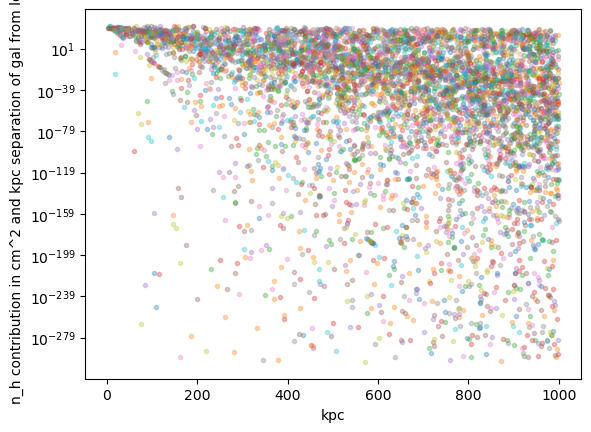

In [32]:
for i in range(10, 50): 
    imp_name = 'ImParams_RT_host'
    close_gal_name = 'CloseGal_RT_host'
    
    all_imps = np.load(f'/pscratch/sd/j/joygong/Dust/{imp_name}/all_imp_kpcs2_SN_{i}.npy')
    close_gs = np.load(f'/pscratch/sd/j/joygong/Dust/{close_gal_name}/close_gals_SN_{i}.npy')
    
    ## need cond 
    cond = summed_column_density(i, host=False, high=False)[-1]

    # plt.figure(i) 
    plt.plot(all_imps[cond], all_gal_nhs[i][cond], '.', alpha=0.3)
    plt.xlabel('kpc') 
    plt.ylabel('n_h contribution in cm^2 and kpc separation of gal from los')
    plt.yscale('log')
    # plt.title(f'sn {i}')

In [145]:
all_imps[cond][all_imps[cond] < 110]

array([33.87400032, 93.6692603 , 17.0974151 , 33.66283676, 17.82137067,
       37.92079756, 90.92908229])

In [148]:
all_gal_nhs[i][cond][all_imps[cond] < 110].sum()

1.2919426313175693e+21

In [34]:
### try for just until 110 kpc
nh_110 = np.zeros(len(all_gal_nhs))
conds = []

for i in tqdm(range(len(all_gal_nhs))): 
    imp_name = 'ImParams_RT_host'
    close_gal_name = 'CloseGal_RT_host'
    
    all_imps = np.load(f'/pscratch/sd/j/joygong/Dust/{imp_name}/all_imp_kpcs2_SN_{i}.npy')
    close_gs = np.load(f'/pscratch/sd/j/joygong/Dust/{close_gal_name}/close_gals_SN_{i}.npy')
    
    ## need cond 
    cond = summed_column_density(i, host=False, high=False)[-1]
    nh_110[i] = all_gal_nhs[i][cond][all_imps[cond] < 110].sum()
    conds.append(np.where(all_imps[cond] < 110)[0].shape)
    

100%|██████████| 1543/1543 [02:34<00:00,  9.98it/s]


In [208]:
np.mean(np.array(conds))

4.436811406351263

# III. Analysis / Plots

In [ ]:
#### check your binning again it might be sus 

In [33]:
sn_col_dens_no_host = nh_110

bins = np.linspace(np.log10(1e3), np.log10(1e26), 10)
bins = np.power(10, bins)

n, b, c = plt.hist(sn_col_dens_no_host, bins=bins, log=True)
plt.xscale('log') 
plt.xlabel('NH')
plt.ylabel('number of sn')

NameError: name 'nh_110' is not defined

In [195]:
## this is with r_effs just until 110 kpc included

biascor_dropped_colors     # bin
sn_col_dens_no_host = nh_110

no_host_bins = [[] for _ in range(len(b) - 1)]

for i in range(len(b)-1): 
    no_host_bin = sn_col_dens_no_host[(b[i] <= sn_col_dens_no_host) & (sn_col_dens_no_host <= b[i+1])]
    no_host_bins[i] = no_host_bin

    
# dropped_colors = colors[np.setdiff1d(np.arange(0, 1635, 1), nozmatch)]

cbins = [[] for _ in range(len(b) - 1)]

for i in range(len(b)-1): 
    cbin = biascor_dropped_colors[(b[i] <= sn_col_dens_no_host) & (sn_col_dens_no_host <= b[i+1])]
    cbins[i] = cbin

Text(0, 0.5, 'bias-corrected $c$')

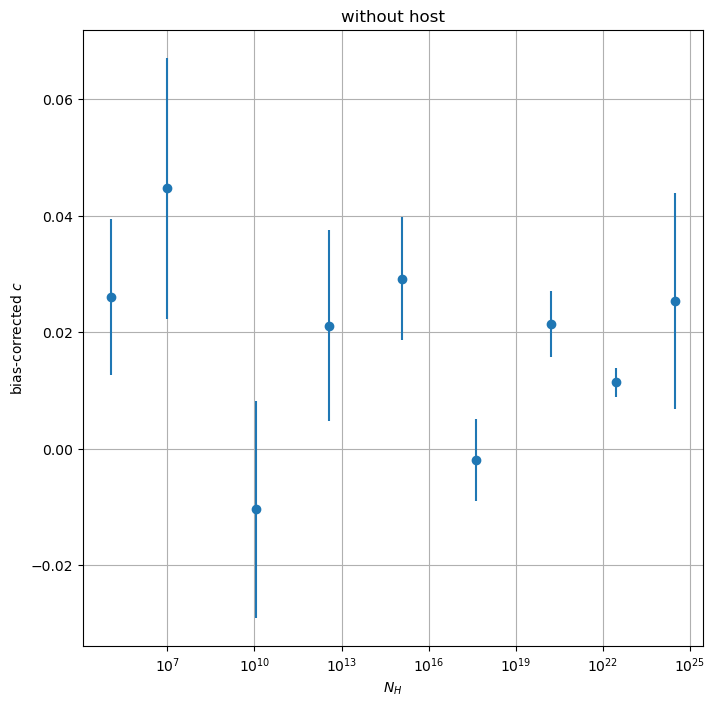

In [196]:
cmeans = [cbins[i][~np.isnan(cbins[i])].mean() for i in range(len(cbins))]                        # mask the nans 
nohostmeans = [no_host_bins[i][~np.isnan(cbins[i])].mean() for i in range(len(no_host_bins))]     # also mask the nans 

c_stds = [np.std(cbins[i][~np.isnan(cbins[i])]) for i in range(len(cbins))]
nohost_stds = [np.std(no_host_bins[i][~np.isnan(cbins[i])]) for i in range(len(no_host_bins))]

nohost_rms = [np.sqrt(np.sum((no_host_bins[i][~np.isnan(cbins[i])] - nohostmeans[i])**2) / len(no_host_bins[i][~np.isnan(cbins[i])])) for i in range(len(no_host_bins))]
rms_color = [np.sqrt(np.sum((cbins[i][~np.isnan(cbins[i])] - cmeans[i])**2) / len(cbins[i][~np.isnan(cbins[i])])) for i in range(len(cbins))]

errmean_color = [rms_color[i] / np.sqrt(len(cbins[i])) for i in range(len(cbins))]

plt.figure(figsize=(8,8))
plt.errorbar(nohostmeans, cmeans, errmean_color, fmt='o')
# plt.ylim(1e19, 1e30)
# plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.title('without host')
plt.xlabel('$N_H$')
plt.ylabel('bias-corrected $c$')
# plt.xlim(1e24, 1e25)

# IV. Trial: 1) Reducing Search Radius, 2) Examining N_H Contributions from Galaxies, 3) More Model-Independent Relations

## 1. Reducing Search Radius

## 2. Examining N_H Contributions from Galaxies

## 3. More Model-Independent Relations